In [12]:
import pandas as pd
import numpy as np
import pwlf
import math
import os
import matplotlib.pyplot as plt
#from GPyOpt.methods import BayesianOptimization

In [ ]:
# Rearrangement signatures. Clustered vs non-clustered rearrangements. We sought
# to separate rearrangements that occurred as focal catastrophic events or focal driver
# amplicons from genome-wide rearrangement mutagenesis using a piecewise constant fitting method. For each sample, both breakpoints of each rearrangement were
# considered individually and all breakpoints were ordered by chromosomal position.
# The inter-rearrangement distance, defined as the number of base pairs from one rearrangement breakpoint to the one immediately preceding it in the reference genome,
# was calculated. Putative regions of clustered rearrangements were identified as having
# an average inter-rearrangement distance that was at least 10 times greater than the
# whole-genome average for the individual sample. Piecewise constant fitting parameters used were γ=25 and kmin=10, with γ as the parameter that controls smoothness
# of segmentation, and kmin the minimum number of breakpoints in a segment.

#input is list of bedpe files(one for each sample)


# a rearrangement is in a cluster if any of its breakpoints are
# mark both breakpoints of a rearrangement as clustered if any is
#functions below expect rows to be organised by chromosomes and ordered by position on the chromosome

 #check whether column svclass is present,
    #if not, compute it
    # if (! "svclass" %in% colnames(sv_bedpe)){
    #   if ("strand1" %in% colnames(sv_bedpe) & "strand2" %in% colnames(sv_bedpe)){
    #     sv_bedpe <- classifyRearrangementsFromBedpe(sv_bedpe)
    #   }else{
    #     message("cannot classify rearrangements: svclass column missing, and cannot compute it because strand1 and strand2 are missing.")
    #   }
    # }

# chrom1    start1  end1    chrom2  start2  end2    sv_id   pe_support  strand1 strand2 svclass svmethod
# X 31906363    31906364    X   33495419    33495420    SVMERGE1    50  +   -   DEL SNOWMAN_BRASS

 #' The column "svclass" should correspond to (Sanger BRASS convention): (strand1/strand2)
#'
#' inversion (+/-), if mates on the same chromosome
#'
#' inversion (-/+), if mates on the same chromosome
#'
#' deletion (+/+), if mates on the same chromosome
#'
#' tandem-duplication (-/-), if mates on the same chromosome
#'
#' translocation, if mates are on different chromosomes

#BREAKPOINT DISTANCE
#sample.rearrs$bkdist <- abs(sample.rearrs$start2 - sample.rearrs$start1)

#rearrs.left <- sv_bedpe[,c('chrom1','start1','sample')]
#rearrs.right <- sv_bedpe[,c('chrom2','start2','sample')]


 #run the algorithm
 # genome.size <- 3 * 10^9
 # MIN.BPS <- 10 # minimal number of breakpoints on a chromosome to do any any segmentation

 #if (sum(sample.bps.flag )>MIN.BPS ) { # if there are enough breakpoints on a chromosome to run pcf


#res = exactPcf(data.points, kmin, gamma, T)

#if (!logScale) { # even if pcf was run on non-logged distances, I log the output

# DOCUMENTATION: https://jekel.me/piecewise_linear_fit_py/examples.html#fit-for-specified-number-of-line-segments

# The fitting of continuous piecewise linear functions has thus far assumed that
# the breakpoint locations are known. In cases when the breakpoint locations are
# unknown, optimization can be used to find the best set of breakpoint locations.
# This formulation requires the user to specify the desired number of line segments.
# Remember there are nb − 1 number of line segments.

#EXAMPLE WITH SV CLASS PRESENT
# chrom1    start1  end1    chrom2  start2  end2    sv_id   pe_support  strand1 strand2 svclass svmethod
# 19    21268384    21268385    19  21327858    21327859    SVMERGE6    9   +   -   DEL SNOWMAN_DELLY


#EXAMPLE WITHOUT SV CLASS PRESENT
# chrom1  start1  end1    chrom2  start2  end2    sample  strand1 strand2
# 1       84379707        84379707        1       84862686        84862686        PD9847a -       -

def isClustered(sample, chrom, start1, start2, i, k, method="sampleIMD"):
    #all the relevant information is stored in sampleToSegments...(sample, chr, start): (segmentAvgDensity, segmentAvgIMD)
    if (sample, chrom, start1) not in sampleToSegments and (sample, chrom, start2) not in sampleToSegments:
        return False
    elif (sample, chrom, start1) in sampleToSegments or (sample, chrom, start2) in sampleToSegments:
        if method == 'tumorIMD' and segmentAvgIMD > i*tumorAvgDensity:
            return True
        elif method == 'tumorDensity' and tumorAvgDensity > i*tumorAvgIMD:
            return True
        elif method == 'sampleIMD' and segmentAvgIMD > i*sampleAvgIMD[sample][0]:
            return True
        elif method == 'sampleDensity' and segmentAvgDensity > i*sampleAvgIMD[sample][1]:
            return True
    else:
        #print (sample, chrom, start1, start2)
        print (" ")

num_events = []
tumorAvgIMD = 0
tumorAvgDensity = 0
sampleAvg = {} #maps each sample to the average IMD in that sample, average density in that sample

totalIMD = 0
totalIMDCount = 0
totalDensity = 0
totalDensityCount = 0

samples = []
index = []

sample_files = ['PD13296a.560_breast.rearrangements.n560.bedpe.tsv']
os.chdir("/Users/azhark/Documents/Alexandrov_Lab/data/SV/data/560_Breast/")

for file in os.listdir('.'):
    if file.endswith(".n560.bedpe.tsv") and file != "PD13296a.560_breast.rearrangements.n560.bedpe.tsv":
        sample_files.append(file)

sampleToSegments = {} #dictionary that maps (sample, chr, start) to its segmentAvgDensity and segmentAvgIMD

all_dfs = []

sub25 = 0
over25 = 0

for file in sample_files:
    print (file)
    df = pd.read_csv(file, sep="\t") #bedpe file format: chrom1, start1, end1, chrom2, start2, end2, strand1, strand2, svclass(optional), sample
    df = df.astype({df.columns[1]: 'int32', df.columns[2]: 'int32', df.columns[5]: 'int32', df.columns[4]: 'int32', df.columns[0]: 'str', df.columns[3]: 'str'})
    sample = file.split('.')[0]
    
    if "svclass" not in df.columns:
        if "strand1" not in df.columns or "strand2" not in df.columns:
            raise Exception("cannot classify rearrangements: svclass column missing, and cannot compute it because strand1 and strand2 are missing.")
        else:
            svclass = []
            for i, row in df.iterrows():
                if row['chrom1'] != row['chrom2']:
                    sv = "trans"
                    svclass.append("trans")
                elif row["strand1"] == '+' and row["strand2"] == '-' or row["strand1"] == '-' and row["strand2"] == '+':
                    sv = "inv"
                    svclass.append("inv")
                elif row["strand1"] == '+' and row["strand2"] == '+':
                    sv = "del"
                    svclass.append("del")
                elif row["strand1"] == '-' and row["strand2"] == '-':
                    sv = "tds"
                    svclass.append("tds")
                else:
                    raise Exception("cannot classify rearrangements: svclass column missing, and cannot compute it because strand1 and strand2 are not in the proper format.")
             
    df["svclass"] = svclass
    
    #GET SIZE
    sizes = [0 for x in svclass]
    for i, (t, s) in enumerate(zip(svclass, sizes)):
        if sv != "trans":
            l = abs(row['start1'] - row['start2']) / 1000000 #megabases
            if l > 0.01 and l <= 0.1:
                size = "10-100kb"
                sizes[i] = size
            elif l > 0.1 and l <= 1:
                size = "100kb-1Mb"
                sizes[i] = size
            elif l > 1 and l <= 10:
                size = "1Mb-10Mb"
                sizes[i] = size
            elif l > 0.001 and l <= 0.010:
                size = "1-10Kb"
                sizes[i] = size
            else:
                size = ">10Mb"
                sizes[i] = size
        else:
            sizes[i] = "0"
            
    df["size_bin"] = sizes
    
    #average IMD
    totalSampleIMD = 0
    sampleIMDCount = 0
    #average density
    totalSampleDensity = 0
    totalDensityCount = 0
    
    num_events.append(df.shape[0] - 1) #number of rearrangements
    chrom_dfs = []
    
    all_chroms = set(list(df.chrom1.unique()) + list(df.chrom2.unique()))
    #print (all_chroms)
    for i, chromosome in enumerate(all_chroms): #apply PCF on a chromosome by chromosome basis

        df = df.filter(items=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'sample', 'svclass', 'size_bin'])
        chrom_df = df[(df.chrom1 == chromosome) | (df.chrom2 == chromosome)]
        #print(chrom_df.shape[0])

        #keep track of partners
        d1 = dict(zip(list(chrom_df['start1']), list(chrom_df['start2'])))
        d2 = dict(zip(list(chrom_df['start2']), list(chrom_df['start1'])))
        d = {**d1, **d2} #combine dictionaries

        lb = chrom_df.iloc[:, 0:2] #get chrom1 and start1
        rb = chrom_df.iloc[:, 3:5] #get chrom2 and start2
        rest = chrom_df.iloc[:, 6:]
        
        
        lb = pd.DataFrame(np.concatenate((lb.values, rest.values), axis=1))
        rb = pd.DataFrame(np.concatenate((rb.values, rest.values), axis=1))
        
        lb.columns = ['chrom1', 'start1', 'sample', 'svclass', 'size_bin']
        rb.columns = ['chrom2', 'start2', 'sample', 'svclass', 'size_bin']
        
        #if either the right or left breakpoint is on this particular chromosome
        chrom = 1
        chr_lb = lb[lb.chrom1 == chromosome]
        chr_rb = rb[rb.chrom2 == chromosome]
        chrom_df = pd.DataFrame(np.concatenate((chr_lb.values, chr_rb.values), axis=0))
        chrom_df.columns = ['chrom', 'start', 'sample', 'svclass', 'size_bin']
        assert(chrom_df['chrom'].nunique() == 1)

        #sort on last column which is start coordinate
        chrom_df = chrom_df.sort_values(chrom_df.columns[1]) #CHROM, START
        #calculate inter-rearrangement distance
        coords = list(chrom_df[chrom_df.columns[1]])
        coords = sorted(coords)
        #print (coords)
        chrom_inter_distances = []
        #defined as the number of base pairs from one rearrangement breakpoint to the one immediately preceding it in the reference genome
        for i in range(1, len(coords)):
            j = i-1
            while coords[j] == d[coords[i]]: #check if previous breakpoint is partner of this breakpoint, if it is, avoid it
                j=j-1
            if j >= 0:
                dist = coords[i] - coords[j]
            else:
                dist = 0
            assert(dist >= 0)

            chrom_inter_distances.append(dist)

        chrom_inter_distances = [0] + chrom_inter_distances #first IMD is 0 because there is no breakpoint preceding it
        #log inter-distances
        for i in range(len(chrom_inter_distances)):
            if chrom_inter_distances[i] != 0:
                chrom_inter_distances[i] = math.log(chrom_inter_distances[i], 10)
        chrom_df['IMD'] = chrom_inter_distances
        
        chrom_df.to_csv("/Users/azhark/Documents/Alexandrov_Lab/data/SV/data/560_Breast/IMD/" + sample + "_" + chromosome + ".IMD.tsv", sep="\t", index=False)
        all_dfs.append(chrom_df)
        
master_df = pd.concat([all_dfs])            
master_df.to_csv("/Users/azhark/Documents/Alexandrov_Lab/data/SV/data/560_Breast/ALL.560_breast.rearrangements.IMD.tsv", sep="\t", index=False)


#         totalSampleIMD += np.array(chrom_inter_distances).sum()
#         sampleIMDCount += len(chrom_inter_distances)

#         totalIMD += np.array(chrom_inter_distances).sum()
#         totalIMDCount += len(chrom_inter_distances)
        
#         if len(chrom_inter_distances) >= 25:
#             over25 += 1
#         else:
#             sub25 += 1

In [ ]:
        #APPLY PCF
        gamma = 25 #number of segments(smoothness of segmentation)
        min_breakpoints = 10 # minimal number of breakpoints on a chromosome to do any any segmentation
        genome_size = 3 * 10^9

        if len(chrom_inter_distances) >= min_breakpoints:
            #initialize piecwise linear fit with your x and y data
            xs = list(chrom_df[chrom_df.columns[-2]])
#             print (len(xs))
#             print (len(chrom_inter_distances))
            assert(len(xs) == len(chrom_inter_distances))
            PWLF = pwlf.PiecewiseLinFit(xs, chrom_inter_distances)
            res = PWLF.fit(gamma)
            breakpoints = [int(x) for x in res]
            segments = []
            for i, b in enumerate(breakpoints):
                if i == 0:
                    segments.append((0, b))
                else:
                    segments.append((breakpoints[i-1], b))
        else: #this chromosome does not have enough breakpoints on it
            continue
        print (segments)
        for seg in segments:
            s = chrom_df[chrom_df[chrom_df.columns[1]]==seg[0]].index.values.astype(int)[0] #get the index of the start of segment
            e = chrom_df[chrom_df[chrom_df.columns[1]]==seg[1]].index.values.astype(int)[0] #get the index of the end of segment
            segment_df = chrom_df.loc[s:e]
            locs = set(list(segment_df.iloc[:, -2])) #all breakpoints along the chromosome
            fname = sample + '_' + str(i) + '_segment.tsv'
            segment_df.to_csv('/Users/azhark/Documents/Alexandrov_Lab/data/SV/data/segments/560_Breast/' + fname, sep='\t')
            segmentAvgDensity = len(locs) / segment_length
            segmentAvgIMD = segment_df['IMD'].mean()
            for chrom, start, in zip(segment_df.iloc[:, 0], segment_df.iloc[:, 1]):
                sampleToSegments[(sample, chrom, start)] = (segmentAvgDensity, segmentAvgIMD)

    if "svclass" not in df.columns:
        if "strand1" not in df.columns or "strand2" not in df.columns:
            raise Exception("cannot classify rearrangements: svclass column missing, and cannot compute it because strand1 and strand2 are missing.")
        else:
            svclass = []
            for i, row in df.iterrows():
                if row['chrom1'] != row['chrom2']:
                    sv = "trans"
                    svclass.append("trans")
                elif row["strand1"] == '+' and row["strand2"] == '-' or row["strand1"] == '-' and row["strand2"] == '+':
                    sv = "inv"
                    svclass.append("inv")
                elif row["strand1"] == '+' and row["strand2"] == '+':
                    sv = "del"
                    svclass.append("del")
                elif row["strand1"] == '-' and row["strand2"] == '-':
                    sv = "tds"
                    svclass.append("tds")
                else:
                    raise Exception("cannot classify rearrangements: svclass column missing, and cannot compute it because strand1 and strand2 are not in the proper format.")

    all_dfs.append(df)

#make sample by feature matrix for nmf with rows as features and samples as columns
features = []
with open('rearrangement_features.txt') as f:
    for line in f:
        features.append(line.strip())
assert(len(features) == 32)
matrix = pd.DataFrame(index=features, columns=samples)

clustered = []
i = 10
k = 10
final_df = pd.concat(all_dfs)


# for file in sample_files:
#     df = pd.read_csv(sample, sep="\t") #bedpe file format: chrom1, start1, end1, chrom2, start2, end2, strand1, strand2, svclass(optional), sample
#     df = df.astype({df.columns[1]: 'int32', df.columns[2]: 'int32', df.columns[5]: 'int32', df.columns[4]: 'int32', df.columns[0]: 'str', df.columns[0]: 'str'})
#     sample = file.split('.')[0]
#     for chr1, start1, chr2, start2, sample in zip(df['chrom1'], df['start1'], df['chrom2'], df['start2'], df['sample']):
#         flag = False
#         if (sample,  chr1, start1) in sampleToSegments:
#             if isClustered(sample, chrom, start1, start2, i, k, method="sampleIMD"):
#                 flag = True
#                 clustered.append("clustered")
#         if (sample,  chr2, start2) in sampleToSegments:
#             if isClustered(sample, chrom, start1, start2, i, k, method="sampleIMD"):
#                 flag = True
#                 clustered.append("clustered")
#         if not flag:
#             clustered.append("non-clustered")

# for s,c1,c2,c3 in zip(df["sample"], df["clustered"], df['svclass'], df["size_bin"]):
#     row = c1 + "_" + c2 + "_" + c3
#     column = s
#     matrix.at[row, column] += 1 

In [5]:
print (sub25)
print (over25)

5969
1879


In [26]:
lb.head()

,0,1,2,3,4
0,1,35276289,PD13296a,trans,0
1,1,35276510,PD13296a,trans,0
2,1,37201274,PD13296a,trans,0
3,1,42120456,PD13296a,trans,0
4,1,42123907,PD13296a,trans,0


In [5]:
imd.size_bin.unique()

array(['>10Mb', '1Mb-10Mb', '1-10Kb', '100kb-1Mb', '10-100kb'],
      dtype=object)

1


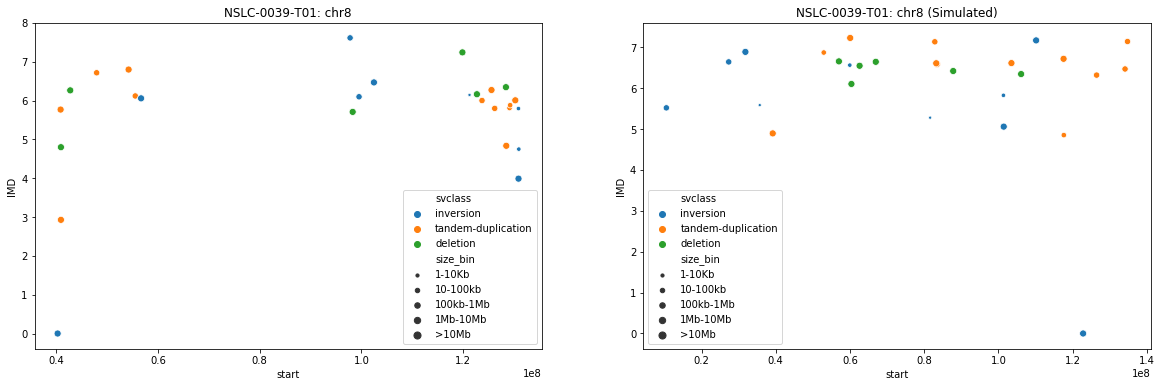

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import pwlf
import math
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#         chrom   start   sample  svclass size_bin        IMD
# 7       7365075 NSLC-0057-T01   inversion       1-10Kb  0.0
# 7       7369129 NSLC-0057-T01   inversion       1-10Kb  0.0

input_dir = "/Users/azhark/iCloud/Sherlock-Lung/segments/"
os.chdir(input_dir)

project = 'Sherlock-Lung'
output_path = "/Users/azhark/iCloud/Alexandrov_Lab/results/"
#pp = PdfPages(output_path + project + 'IMD_plots' + '.pdf')
pp = PdfPages(project + '_IMD_plots' + '.pdf')

sizes  = {'>10Mb':50, '1Mb-10Mb':40, '1-10Kb':10, '100kb-1Mb':30, '10-100kb':20}
size_order = ['1-10Kb', '10-100kb', '100kb-1Mb', '1Mb-10Mb', '>10Mb']
count = 0
for file in os.listdir('.'):
    if file.endswith(".IMD.tsv"):
        sample = file.split(".")[0].split("_")[0]
        c = file.split(".")[0].split("_")[-1]
        imd = pd.read_csv(file, sep="\t")
        sim_imd = pd.read_csv(file + '.simulated', sep="\t")
        if imd.shape[0] > 0:
            fig, axes = plt.subplots(1, 2, figsize=(20, 6))
            a = sns.scatterplot("start", "IMD", data=imd, hue="svclass", size="size_bin", sizes=sizes, size_order=size_order, legend="full", ax=axes[0]).set_title(sample + ": " + "chr" + str(c))
            b = sns.scatterplot("start", "IMD", data=sim_imd, hue="svclass", size="size_bin", sizes=sizes, size_order=size_order, legend="full", ax=axes[1]).set_title(sample + ": " + "chr" + str(c) + ' (Simulated)')
            pp.savefig(fig, dpi=150, bbox_inches='tight')
            count+=1
            
pp.close()        
print (count)


In [ ]:
input_dir = "/Users/azhark/iCloud/Sherlock-Lung/segments/"
os.chdir(input_dir)

project = '560-Breast'
output_path = "/Users/azhark/iCloud/Alexandrov_Lab/results/"
#pp = PdfPages(output_path + project + 'IMD_plots' + '.pdf')
pp = PdfPages(project + '_IMD_plots' + '.pdf')

count = 0
for file in os.listdir('.'):
    if file.endswith(".IMD.tsv"):
        sample = file.split()
        imd = pd.read_csv(file, sep="\t")
        sim_imd = pd.read_csv(file + '.simulated', sep="\t")
        if imd.shape[0] > 100:
            fig, axes = plt.subplots(1, 2, figsize=(20, 6))
            a = sns.scatterplot("start", "IMD", data=imd, hue="svclass", size="size_bin", legend="full", ax=axes[0])
            b = sns.scatterplot("start", "IMD", data=sim_imd, hue="svclass", size="size_bin", legend="full", ax=axes[1])
            pp.savefig(fig, dpi=150, bbox_inches='tight')
            count+=1
pp.close()        
print (count)